# Word feature appearance/disapearance susceptibility, excluding stopwords

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
STOPWORDS = 'exclude'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.stats.proportion import multinomial_proportions_confint
from progressbar import ProgressBar

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, quantile_interval, get_nlp

config = GistsConfiguration.get_solo()
nlp = get_nlp()

## 2 Appearance and disappearance for categorical variables

### A note on how appearances/disappearances can be measured

Here are the possible approaches to compare to sentences (lists of tokens, lemmas, POSs, whatever).

**Bag of words**

Look at the two lists as unordered bags, and look at one minus the other.

Good:
* Gives you bags of appeared/disappeared items (you weigh each item by the number of times it is present in a bag)
* You know that each appeared/disappeared item in your bags correspond to items that have effectively appeared or disappeared

Bad:
* You can't place the appearances/disappearances in the parent/child sentences (unless the item is the only one of its kind in the parent or child sentences)
* Those bags don't necessarily cover *all* appearances/disappearances: a word could have been replaced by another of same category (you don't see that), or could have been moved in the sentence, or both

**Minimal path from one to the other**

Compute the Levenshtein shortest paths (with exchange) transforming one list into the other, and count replacement/insertion/deletion on the words involved in the shortest paths (weighing accordingly if there are several paths).

Good:
* Gives you bags of appeared/disappeared items
* Lets you place the appearanecs/disappearances in the parent/child sentences

Bad:
* It doesn't necessarily represent the psychological path taken (if that notion makes sense at all). In a way, it's half-baked: you start modelling the transformation process, but without any syntax trees or psychological considerations.
* On tokens, you will count a change in inflection as a replacement (but you could also ignore those)
* On lemmas, you don't have the problem from the previous point, but you lose precision in the transformation path
* Moving a part of the sentence (a syntax subtree exchange) will count as many exchanges (or deletion+insertion) as there are words to move

**Conclusion**

Go with bags of words: it's simpler and a more clear-cut choice, since the second option is half-baked.

### 2.1 Setup

We need a few helper functions first

In [4]:
def additional_features(parent, child):
    return {
        'oc_rate': np.nan if child is None else parent.oc_distance(child),
        'oc_transmitted': np.nan if child is None else int(parent.oc_distance(child) == 0),
        'token_length': len(parent.tokens),
        'content_length': len(parent.content_tokens),
    }

def base(parent, child):
    return {
        # indices
        'tree_id': parent.tree.id,
        'parent_id': parent.id,
        'branch_id': parent.head.id if parent.parent is not None else child.head.id,
        'child_id': child.id if child is not None else np.nan,
        # independent variables
        'depth': parent.depth,
        'is_root': parent.parent is None,
        'root_memorable': int(parent.tree.id % 2 == 0),
    }

def final_feature_name(feature, rel):
    return feature + (('-rel' + rel) if rel is not None else '')

def rows(parent, child, feature, rel=None):
    parent_values = parent.features(feature, rel=rel, stopwords=STOPWORDS)
    parent_counts = Counter(parent_values)
    child_values = child.features(feature, rel=rel, stopwords=STOPWORDS)
    child_counts = Counter(child_values)
    app_counts = child_counts - parent_counts
    dis_counts = parent_counts - child_counts
    
    for value in set(parent_values).union(child_values):
        if np.isnan(value):
            continue

        # Get the value's quantile position.
        parent_start_quantile, parent_stop_quantile = quantile_interval(parent_values, value)
        child_start_quantile, child_stop_quantile = quantile_interval(child_values, value)
        
        row = base(parent, child)
        row.update(additional_features(parent, child))
        row.update({
            'feature': final_feature_name(feature, rel),
            'value': value,
            'parent_count': parent_counts[value],
            'child_count': child_counts[value],
            'app_count': app_counts[value],
            'dis_count': dis_counts[value],
            'parent_start_quantile': parent_start_quantile,
            'parent_stop_quantile': parent_stop_quantile,
            'child_start_quantile': child_start_quantile,
            'child_stop_quantile': child_stop_quantile,
        })
        yield row

Now build the master DataFrame that we plot below

In [5]:
categorical_features = list(Sentence.CATEGORICAL_WORD_FEATURES) + ['depth_under', 'depth_above']
continuous_features = sorted(set(Sentence.WORD_FEATURES.keys())
                             .difference(categorical_features + ['sentence_prop']))
continuous_rel_features = list(map(lambda f: final_feature_name(f, 'mean'), continuous_features))

data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    for parent in tree.sentences.kept:

        if parent.depth >= config.target_branch_depth:
            # Ignore reformulations with out-of-shape children
            continue
        
        children = parent.children.kept
        if len(children) == 0:
            # Ignore leaves, we already saw them
            # with their parent
            continue
        
        for child in children:
            for feature in continuous_features:
                for row in rows(parent, child, feature, rel=None):
                    data.append(row)
                for row in rows(parent, child, feature, rel='mean'):
                    data.append(row)
            for feature in categorical_features:
                for row in rows(parent, child, feature, rel=None):
                    data.append(row)
                # No sentence-relative values for categorical features

data = pd.DataFrame(data)

index = sorted(set(data.columns).difference(['value', 'feature']))

100% (50 of 50) |#########################| Elapsed Time: 0:04:17 Time: 0:04:17


Each sentence counts for one in the plots below, so we have to weigh each recorded word accordingly

In [6]:
# Weight is 1, at first
data['weight_parent'] = 1
data['weight_child'] = 1
data['weight_app'] = 1
data['weight_dis'] = 1

# Divided by the number of words counted in the parent...
print('Computing parent sentence word weights')
data['weight_parent'] = data\
    .groupby(['parent_id', 'child_id', 'feature'])['weight_parent']\
    .transform(lambda x: x / data.loc[x.index]['parent_count'].sum())

# ... in the child...
print('Computing child sentence word weights')
data['weight_child'] = data\
    .groupby(['parent_id', 'child_id', 'feature'])['weight_child']\
    .transform(lambda x: x / data.loc[x.index]['child_count'].sum())

# ... or by the number of appearing or disappearing words
print('Computing appearing word weights')
data['weight_app'] = data\
    .groupby(['parent_id', 'child_id', 'feature'])['weight_app']\
    .transform(lambda x: x / data.loc[x.index]['app_count'].sum())
print('Computing disappearing word weights')
data['weight_dis'] = data\
    .groupby(['parent_id', 'child_id', 'feature'])['weight_dis']\
    .transform(lambda x: x / data.loc[x.index]['dis_count'].sum())

Computing parent sentence word weights
Computing child sentence word weights
Computing appearing word weights
Computing disappearing word weights


Finally, a helper function to compute categorical feature susceptibilities

In [7]:
def categorical_counts_proportions_suscepts(df, feature, rename_index=None):
    # Compute counts. We do these separately since the groupings are different.
    parent_counts = df[df.feature == feature]\
        .groupby('value')['parent_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_parent']).sum())\
        .rename_axis(feature)
    child_counts = df[df.feature == feature]\
        .groupby('value')['child_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_child']).sum())\
        .rename_axis(feature)
    appeared_counts = df[df.feature == feature]\
        .groupby('value')['app_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_app']).sum())\
        .rename_axis(feature)
    disappeared_counts = df[df.feature == feature]\
        .groupby('value')['dis_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_dis']).sum())\
        .rename_axis(feature)
    
    # Massage into DataFrames, renaming the index
    counts = pd.DataFrame({'parent': parent_counts,
                           'child': child_counts,
                           'appeared': appeared_counts,
                           'disappeared': disappeared_counts})
    if rename_index is not None:
        counts = counts.rename(index=rename_index)
    proportions = counts / counts.sum()
    suscepts = pd.DataFrame(
       {'appeared': proportions.appeared / proportions.child,
        'disappeared': proportions.disappeared / proportions.parent}
    )
    
    return counts, proportions, suscepts

And the actual plotting function

In [8]:
def plot_susties(counts, proportions, suscepts, axes=None,
                 count_plot_kws={}, suscept_plot_kws={}, ci_kws={}):
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    feature = counts.index.name
    texfeature = feature.replace('_', ' ')
    ci_lw = ci_kws.pop('lw', 4)
    ci_color = ci_kws.pop('color', 'grey')

    #
    # Raw appeared/disappeared/parent values
    #

    proportions[['parent', 'appeared', 'disappeared']]\
        .rename(columns={'parent': '$s_{{{}}}^0$'.format(texfeature),
                         'appeared': '$s_{{{}}}^+$'.format(texfeature),
                         'disappeared': '$s_{{{}}}^-$'.format(texfeature)})\
        .plot(ax=axes[0], kind='bar', width=.75, **count_plot_kws)
    # With their CIs
    cis_appeared = multinomial_proportions_confint(
        counts.appeared.round(), method='goodman')
    cis_disappeared = multinomial_proportions_confint(
        counts.disappeared.round(), method='goodman')
    for i in range(len(counts)):
        axes[0].plot([i, i], cis_appeared[i],
                     lw=ci_lw, color=ci_color,
                     label='95% CI' if i == 0 else None)
        axes[0].plot([i+.25, i+.25], cis_disappeared[i],
                     lw=ci_lw, color=ci_color)
    # Set chrome
    axes[0].legend()
    axes[0].set_ylabel('Fraction of total counted')
    
    #
    # Substitutability values
    #
    
    suscepts[['appeared', 'disappeared']]\
        .rename(columns={'appeared': r'$\sigma_{{{}}}^+$'.format(texfeature),
                         'disappeared': r'$\sigma_{{{}}}^-$'.format(texfeature)})\
        .apply(np.log10)\
        .plot(ax=axes[1], kind='bar', legend=True,
              color=sb.color_palette()[1:3], **suscept_plot_kws)
    axes[1].set_ylabel('Susceptibility')
    # With their CIs
    for i in range(len(counts)):
        axes[1].plot([i-.125, i-.125],
                     np.log10(cis_appeared[i] / proportions.child.iloc[i]),
                     lw=ci_lw, color=ci_color,
                     label='95% CI' if i == 0 else None,
                     **ci_kws)
        axes[1].plot([i+.125, i+.125],
                     np.log10(cis_disappeared[i] / proportions.parent.iloc[i]),
                     lw=ci_lw, color=ci_color, **ci_kws)
    axes[1].plot([-1, len(counts)], [0, 0], '--',
                 color=sb.desaturate(sb.color_palette()[0], 0.2),
                 label=r'$\mathcal{H}_0$')
    # Set chrome
    axes[1].legend(loc='best')
    axes[1].set_yticklabels(['$10^{{{:.2}}}$'.format(tick)
                             for tick in axes[1].get_yticks()])
    
    return axes

### 2.2 POS Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in true_divide

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in true_divide

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10



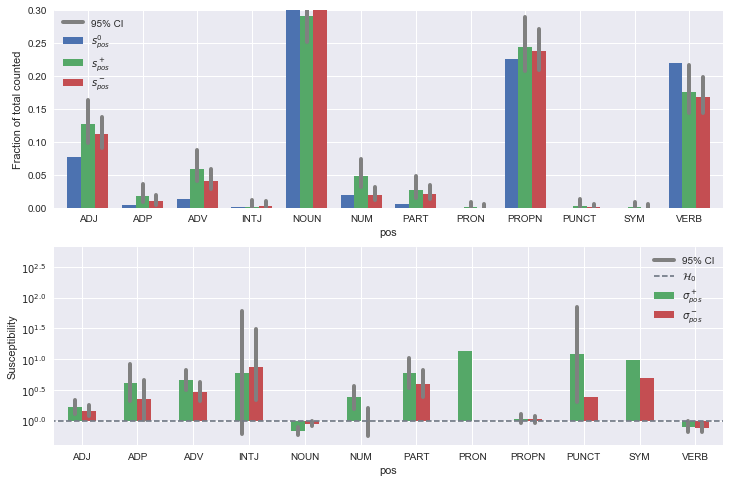

In [9]:
POS_counts, POS_proportions, POS_suscepts = categorical_counts_proportions_suscepts(
    data, 'pos', rename_index=lambda n: nlp.vocab.strings[int(n)])
POS_counts = POS_counts[POS_counts.index != 'X']
POS_proportions = POS_proportions[POS_proportions.index != 'X']
POS_suscepts = POS_suscepts[POS_suscepts.index != 'X']

axes = plot_susties(POS_counts, POS_proportions, POS_suscepts,
                    count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0})
axes[0].set_ylim((0, .3));

### 2.3 "Dependency relation" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10



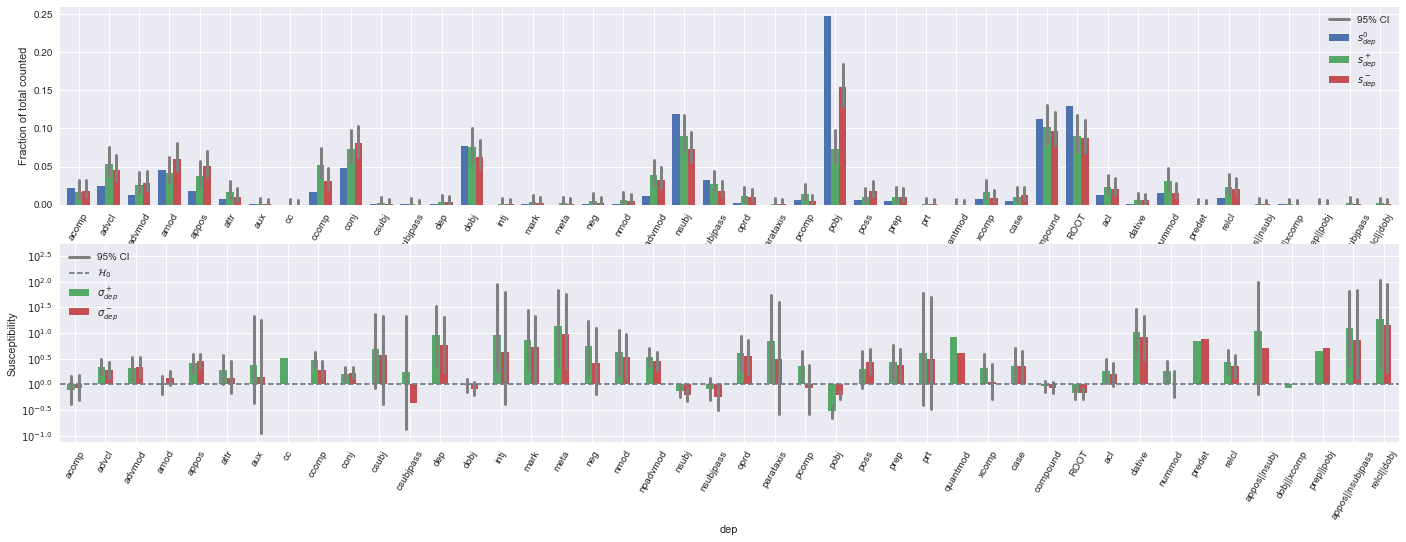

In [10]:
dep_counts, dep_proportions, dep_suscepts = categorical_counts_proportions_suscepts(
    data, 'dep', rename_index=lambda n: nlp.vocab.strings[int(n)])

fig, axes = plt.subplots(2, 1, figsize=(24, 8))
plot_susties(dep_counts, dep_proportions, dep_suscepts,
             axes=axes,
             count_plot_kws={'rot': 60}, suscept_plot_kws={'rot': 60},
             ci_kws={'lw': 3});

### 2.4 "Depth of dependency tree below token" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10



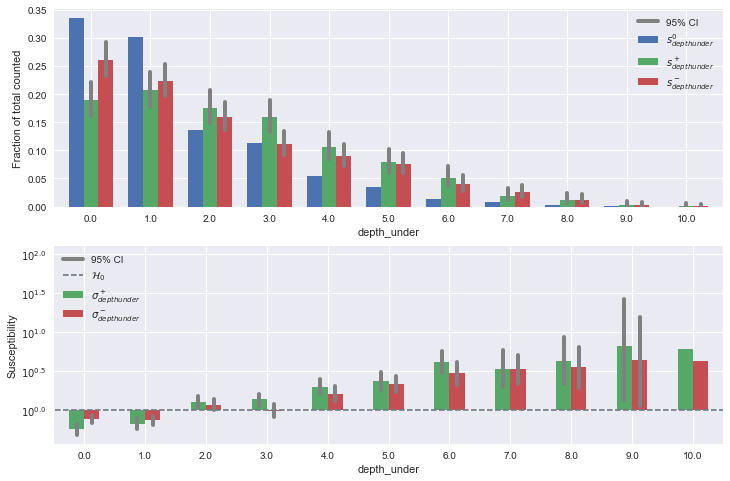

In [11]:
depth_below_counts, depth_below_proportions, depth_below_suscepts = \
    categorical_counts_proportions_suscepts(data, 'depth_under')

plot_susties(depth_below_counts, depth_below_proportions, depth_below_suscepts,
             count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0});

### 2.5 "Depth of dependency tree above token" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10



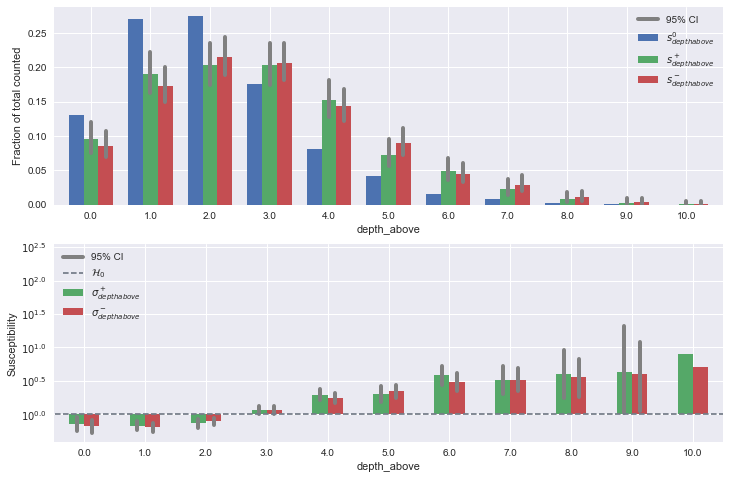

In [12]:
depth_above_counts, depth_above_proportions, depth_above_suscepts = \
    categorical_counts_proportions_suscepts(data, 'depth_above')

plot_susties(depth_above_counts, depth_above_proportions, depth_above_suscepts,
             count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0});

## 3 Appearances and disappearances for continuous variables

### 3.1 Setup

Our plotting function

In [13]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    quantiles = kwargs.get('quantiles', False)
    value = data.value
    binning = kwargs.get('binning', 5)
    tipe = kwargs['tipe']
    ctipe = 'child' if tipe == 'app' else 'parent'
    stripone = kwargs.get('stripone', False)
    
    # Compute binning on reconstituted distribution
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    if not stripone:
        distribution = pd.Series([v for (v, count) in zip(value, data[ctipe + '_count'])
                                  for _ in range(count)])
    else:
        distribution = pd.Series([v for (v, count) in zip(value[value != 1],
                                                          data[value != 1][ctipe + '_count'])
                                  for _ in range(count)])
    for bin_count in range(binning, 0, -1):
        try:
            _, bins = cut(distribution, bin_count, labels=False,
                          retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    if bin_count <= 1:
        return
    if stripone:
        bins[-1] = 1
    middles = (bins[:-1] + bins[1:]) / 2
    value_bins = np.nan * np.ones_like(value)
    for i in range(bin_count):
        value_bins[(bins[i] <= value) & (value < bins[i + 1])] = i
    value_bins[value == bins[-1]] = bin_count - 1

    # Compute bin heights
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[value_bins == i][tipe + '_count']
                      * data[value_bins == i]['weight_' + tipe]).sum()
        h0s[i] = (data[value_bins == i][ctipe + '_count']
                  * data[value_bins == i]['weight_' + ctipe]).sum()
    total = sum(heights)
    total_h0 = sum(h0s)
    
    # Set any null values of heigths to .5 for confints
    cis = (multinomial_proportions_confint([h or .5 for h in heights.round()],
                                            method='goodman')
           * total_h0 / h0s[:, np.newaxis])
    
    # Plot them
    sigmaphi = (r'\sigma_{\phi}^{'
                + ('+' if tipe == 'app' else '-')
                + '}')
    plt.plot(middles, (heights / total) / (h0s / total_h0), 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${} \mathcal{{H}}_0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.yscale('log')

A helper to plot features in a grid

In [14]:
def plot_grid(data, features, plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data, dropna=False,
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=6, aspect=1.2, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
    return g

### 3.2 Features binned by global word distribution in the dataset

#### 3.2.1 Binning by fixed width

##### 3.2.1.1 Absolute values

In [15]:
def set_ylims(g, lims):
    lower, upper = lims
    preticks = [lower, 1, upper]
    powers = [int(np.floor(np.log10(tick))) for tick in preticks]
    ticks = [np.sign(p+.1) * np.floor(np.sign(p+.1) * tick * 10**(-p)) * 10**p
             for tick, p in zip(preticks, powers)]
    g.set(ylim=lims, yticks=ticks)
    g.set_yticklabels([r'${v} \times 10^{{{p}}}$'.format(v=int(t * 10**(-p)), p=p)
                       for t, p in zip(ticks, powers)])

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in true_divide

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in true_divide



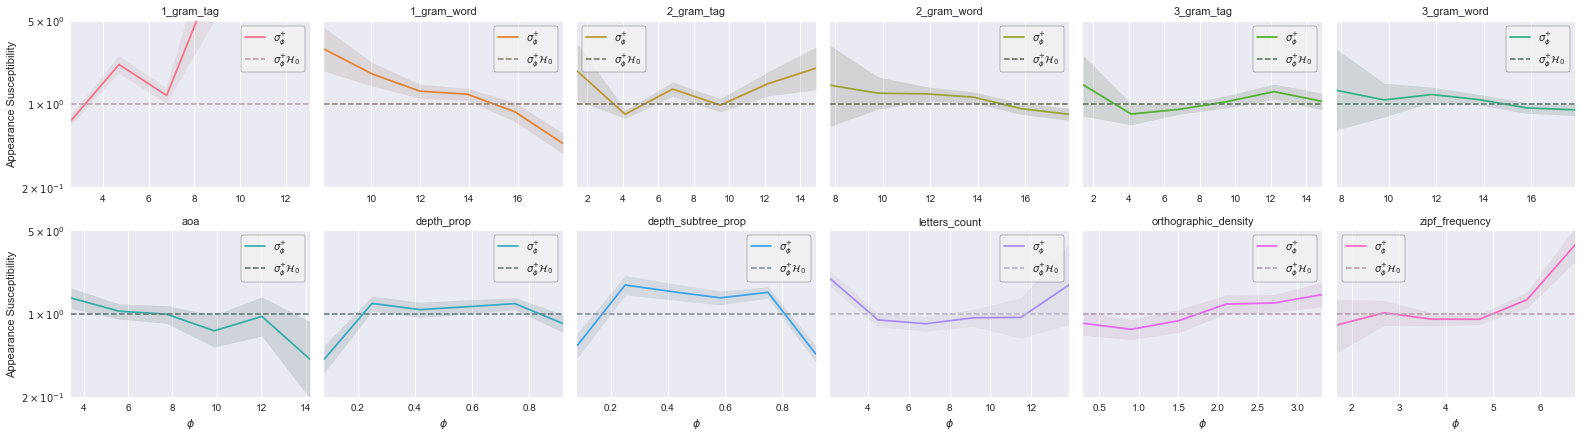

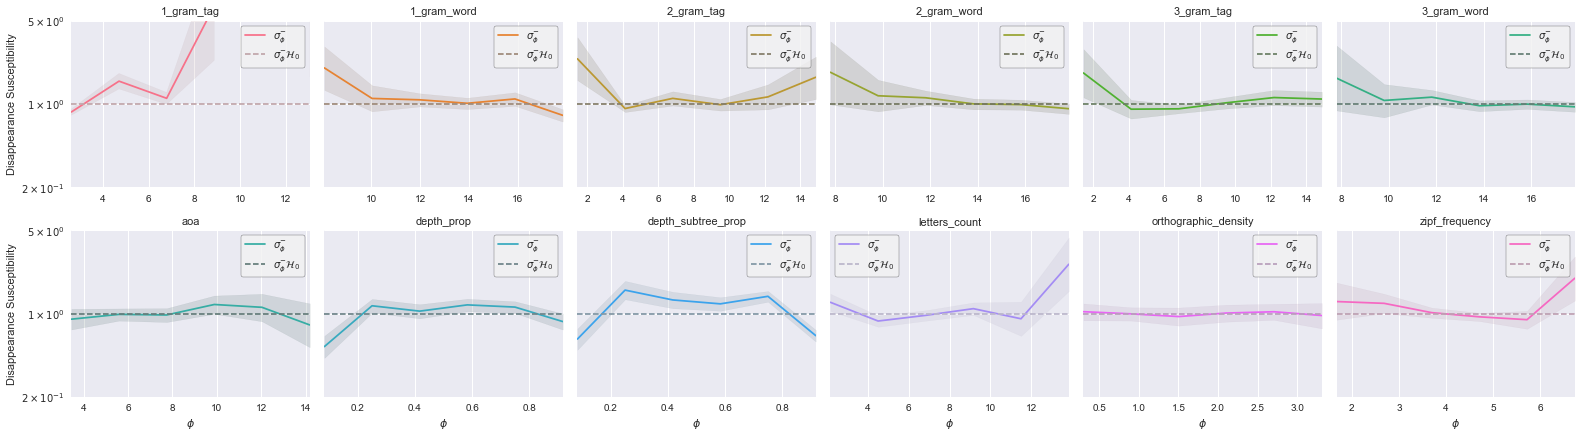

In [16]:
g = plot_grid(data, continuous_features, plot_bin_susties,
              r'$\phi$', 'Appearance Susceptibility',
              plot_kws={'quantiles': False, 'tipe': 'app', 'binning': 6})
set_ylims(g, (.2, 5))

g = plot_grid(data, continuous_features, plot_bin_susties,
              r'$\phi$', 'Disappearance Susceptibility',
              plot_kws={'quantiles': False, 'tipe': 'dis', 'binning': 6})
set_ylims(g, (.2, 5))

##### 3.2.1.2 Sentence-relative values

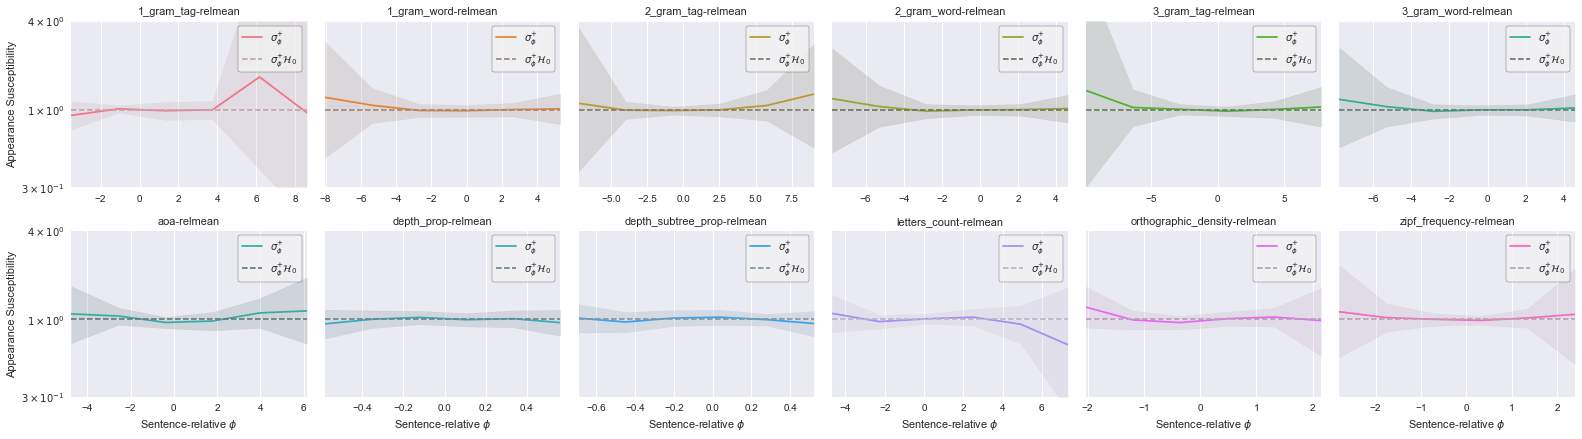

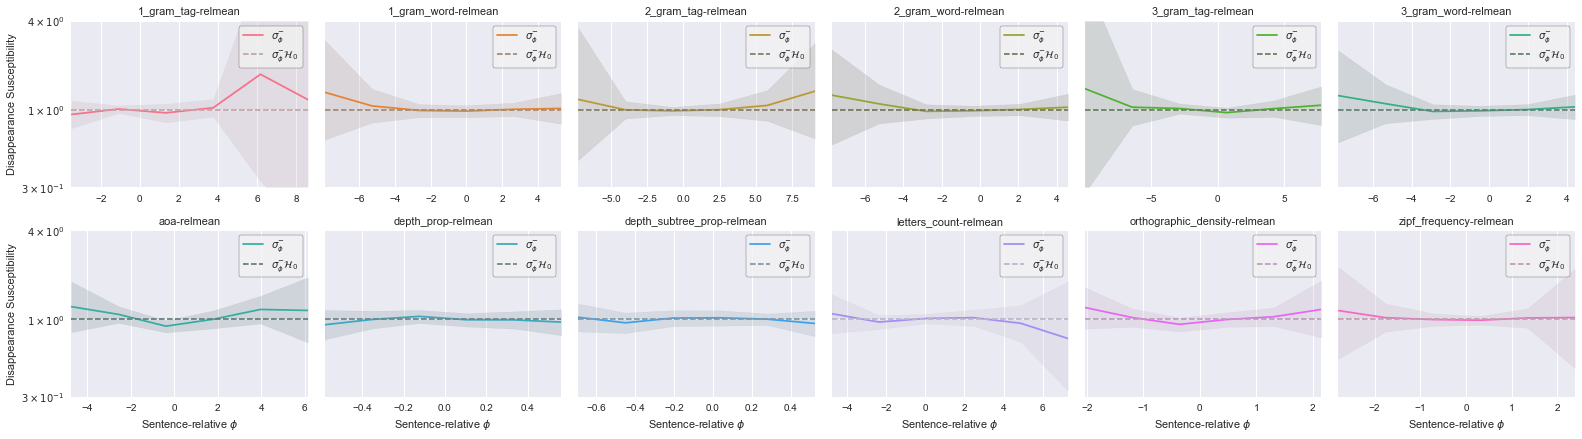

In [17]:
g = plot_grid(data, continuous_rel_features, plot_bin_susties,
              r'Sentence-relative $\phi$', 'Appearance Susceptibility',
              plot_kws={'quantiles': False, 'tipe': 'app', 'binning': 6})
set_ylims(g, (.3, 4))

g = plot_grid(data, continuous_rel_features, plot_bin_susties,
              r'Sentence-relative $\phi$', 'Disappearance Susceptibility',
              plot_kws={'quantiles': False, 'tipe': 'dis', 'binning': 6})
set_ylims(g, (.3, 4))

#### 3.2.2 Binning by quantiles

##### 3.2.2.1 Absolute values

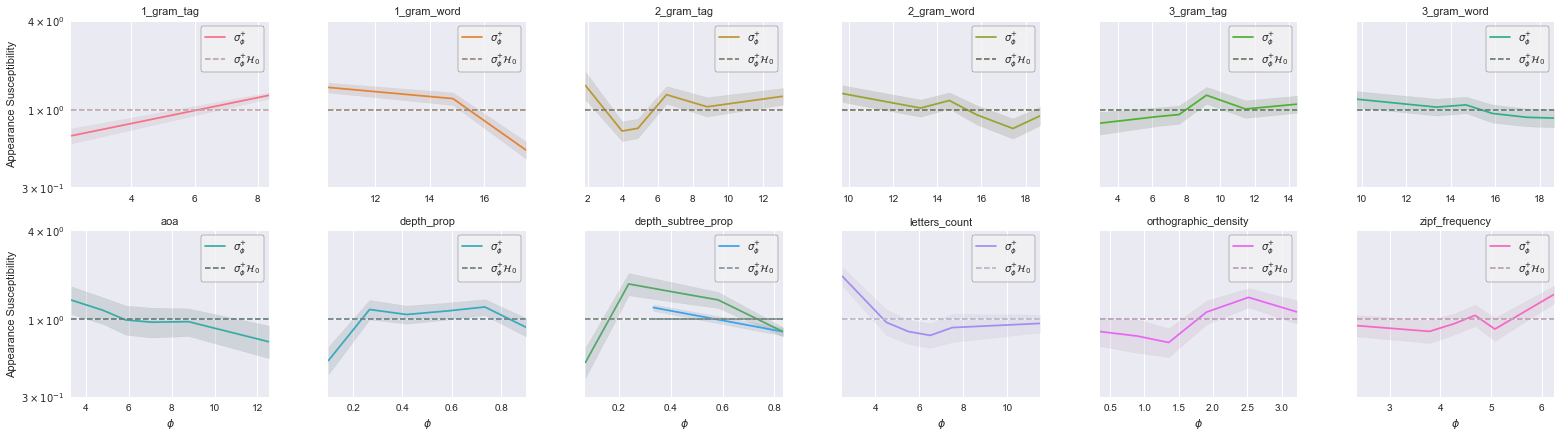

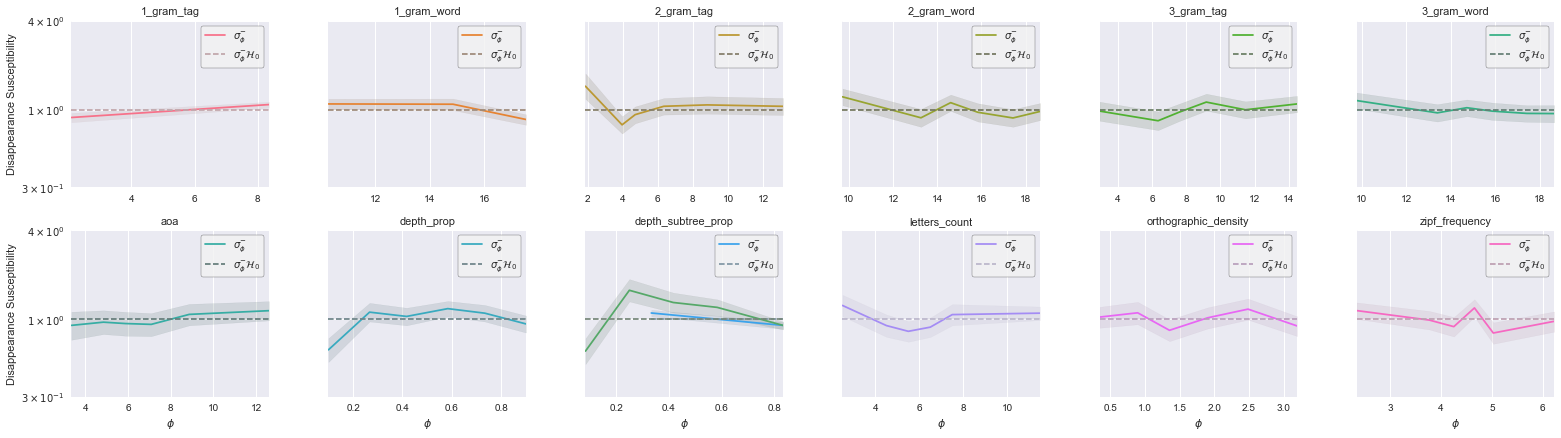

In [18]:
g = plot_grid(data, continuous_features, plot_bin_susties,
              r'$\phi$', 'Appearance Susceptibility',
              plot_kws={'quantiles': True, 'tipe': 'app', 'binning': 6})

# depth_subtree_% has a very skewed distribution (almost all ones),
# so quantile binning never succeeds (there's always overlapping
# bins around the final 1). So we replot it by asking plot_bin_susties()
# to strip the 1 when binning, and re-extend the final bin afterwards.
# We lose the legend for this plot in the process, but that's ok for now.
plt.sca(g.axes[8])
plot_bin_susties(data=data[data.feature == 'depth_subtree_prop'],
                 quantiles=True, tipe='app', binning=6, stripone=True,
                 color=sb.color_palette()[1])
set_ylims(g, (.3, 4))

g = plot_grid(data, continuous_features, plot_bin_susties,
              r'$\phi$', 'Disappearance Susceptibility',
              plot_kws={'quantiles': True, 'tipe': 'dis', 'binning': 6})

# depth_subtree_% has a very skewed distribution (almost all ones),
# so quantile binning never succeeds (there's always overlapping
# bins around the final 1). So we replot it by asking plot_bin_susties()
# to strip the 1 when binning, and re-extend the final bin afterwards.
# We lose the legend for this plot in the process, but that's ok for now.
plt.sca(g.axes[8])
plot_bin_susties(data=data[data.feature == 'depth_subtree_prop'],
                 quantiles=True, tipe='dis', binning=6, stripone=True,
                 color=sb.color_palette()[1])
set_ylims(g, (.3, 4))

##### 3.2.2.2 Sentence-relative values

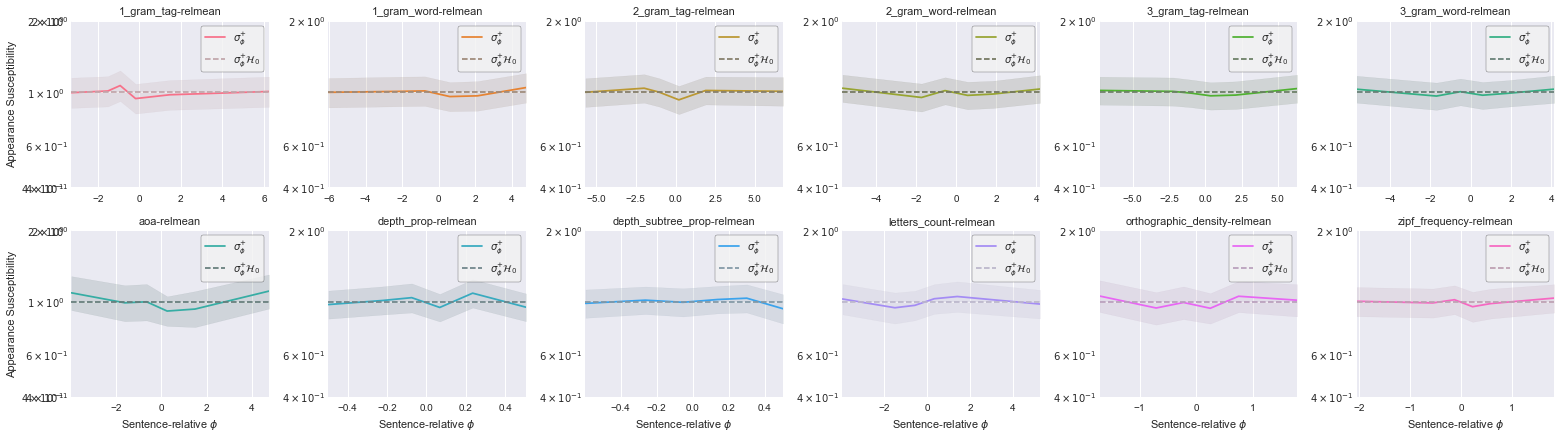

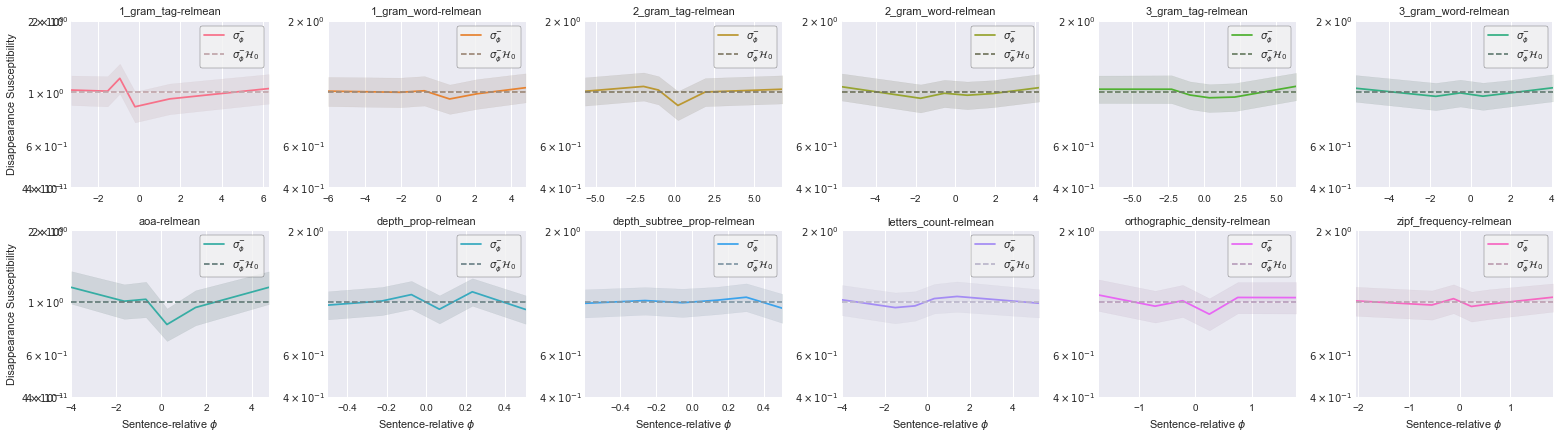

In [19]:
g = plot_grid(data, continuous_rel_features, plot_bin_susties,
              r'Sentence-relative $\phi$', 'Appearance Susceptibility',
              plot_kws={'quantiles': True, 'tipe': 'app', 'binning': 6})
set_ylims(g, (.4, 2))

g = plot_grid(data, continuous_rel_features, plot_bin_susties,
              r'Sentence-relative $\phi$', 'Disappearance Susceptibility',
              plot_kws={'quantiles': True, 'tipe': 'dis', 'binning': 6})
set_ylims(g, (.4, 2))

### 3.3 Features placed in the in-sentence word distributions

#### 3.3.1 Setup

Our plotting function

In [20]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    bin_count = kwargs.get('binning', 5)
    tipe = kwargs['tipe']
    ctipe = 'child' if tipe == 'app' else 'parent'
    
    # Compute bin heights
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    step = 1 / bin_count
    for i in range(bin_count):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data[ctipe + '_stop_quantile'])
                          - bound(limits, data[ctipe + '_start_quantile']))
                         / (data[ctipe + '_stop_quantile'] - data[ctipe + '_start_quantile']))
        heights[i] = \
            (contributions * data['weight_' + tipe] * data[tipe + '_count']).sum()
        h0s[i] = (contributions * data['weight_' + ctipe] * data[ctipe + '_count']).sum()
    total = sum(heights)
    total_h0 = sum(h0s)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total_h0 / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, bin_count + 1)
    plt.plot(x, (heights / total) / (h0s / total_h0),
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(h0s), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(x[0], x[-1])
    plt.yscale('log')

#### 3.3.2 Features placed in the in-sentence word distributions

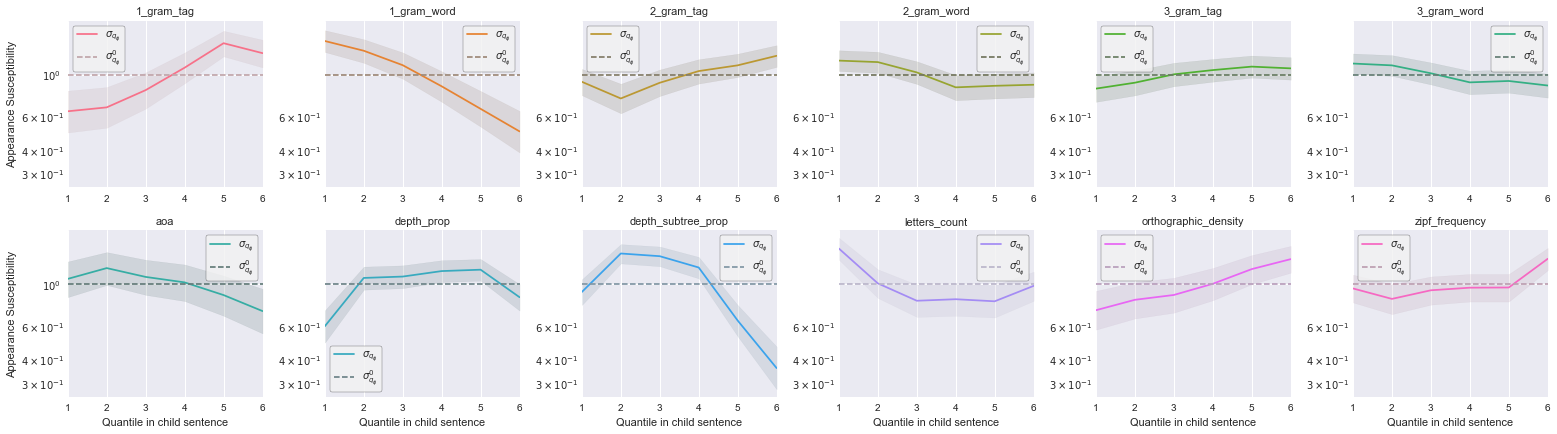

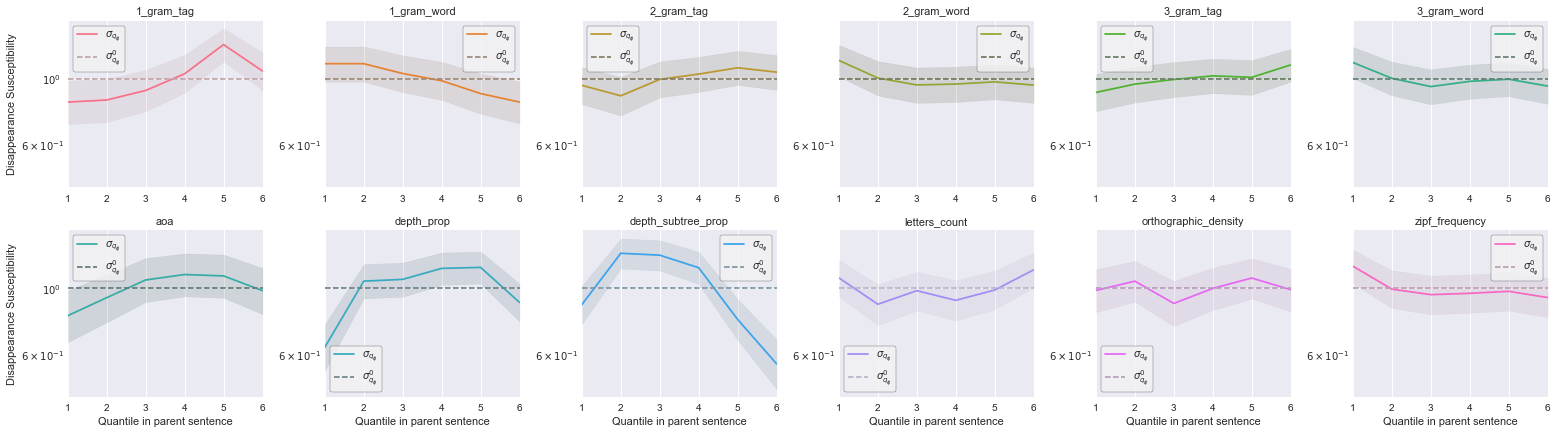

In [21]:
plot_grid(data, continuous_features, plot_sentencequantile_susties,
          'Quantile in child sentence', 'Appearance Susceptibility',
          plot_kws={'tipe': 'app', 'binning': 6})

plot_grid(data, continuous_features, plot_sentencequantile_susties,
          'Quantile in parent sentence', 'Disappearance Susceptibility',
          plot_kws={'tipe': 'dis', 'binning': 6})